In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* This notebook contains the complete code to run the test example of modeling the stock market time serie of Microsoft with LSTM neural networks considering the daily observations extrated between 2010 and 2018. The variations of the example are:
   
   
    1. Modeling the time serie only with LSTM.
    2. Same model, but adding a signal getting from the sentiment analysis of online news as extra feature in the model.

# 1. First model: modeling the stock market time series without any extra features

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')

from time import time

import matplotlib.ticker as tkr
%matplotlib inline

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf

import math

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

* The data set _df test 1_ contains the values of the stock market time serie

In [ ]:
result= pd.read_pickle("/content/drive/MyDrive/data_to_paper_microsoft_case.pkl")

# original time serie (Y)
y = result.MSFT.values
y = y.astype('float32')
y = np.reshape(y, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y)



# training and testing settings (size)
percent_of_training = 0.7
train_size = int(len(y) * percent_of_training)
test_size = len(y) - train_size
#
train_y, test_y = y[0:train_size,:], y[train_size:len(y),:]


def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
look_back = 7


# features of the original time serie (y)
X_train_features_1, y_train = create_dataset(train_y, look_back)
X_test_features_1, y_test = create_dataset(test_y, look_back)




# join the all the features in one
## reshape arrays
X_train_features = np.reshape(X_train_features_1, (X_train_features_1.shape[0], 1, X_train_features_1.shape[1]))
X_test_features  = np.reshape(X_test_features_1, (X_test_features_1.shape[0], 1, X_test_features_1.shape[1]))


In [ ]:
model = Sequential()
model.add(LSTM(200, input_shape=(X_train_features.shape[1], X_train_features.shape[2])))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train_features,y_train, epochs=300, batch_size=25, validation_data=(X_test_features, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0, shuffle=False)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 200)            │       166,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 499,805 (1.91 MB)

 Trainable params: 166,601 (650.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 333,204 (1.27 MB)

In [ ]:
train_predict = model.predict(X_train_features)
test_predict  = model.predict(X_test_features)




#train_predict = scaler.inverse_transform(train_predict)
#Y_train = scaler.inverse_transform(y_train)
#test_predict = scaler.inverse_transform(test_predict)
#Y_test = scaler.inverse_transform(y_test)


print('Train Mean Absolute Error:', mean_absolute_error(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(np.reshape(y_test,(y_test.shape[0],1)), test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(y_test,(y_test.shape[0],1)), test_predict[:,0])))

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train Mean Absolute Error: 0.006677914410829544
Train Root Mean Squared Error: 0.009694434496506437
Test Mean Absolute Error: 0.032610371708869934
Test Root Mean Squared Error: 0.039787710156538876


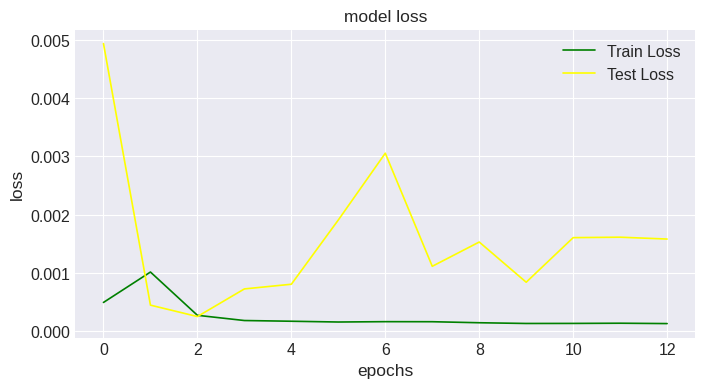

In [ ]:
plt.figure(figsize=(8,4))
plt.style.use('seaborn-v0_8-dark')

plt.plot(history.history['loss'], label='Train Loss',color="green")
plt.plot(history.history['val_loss'], label='Test Loss',color = "yellow")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.grid()

plt.show();

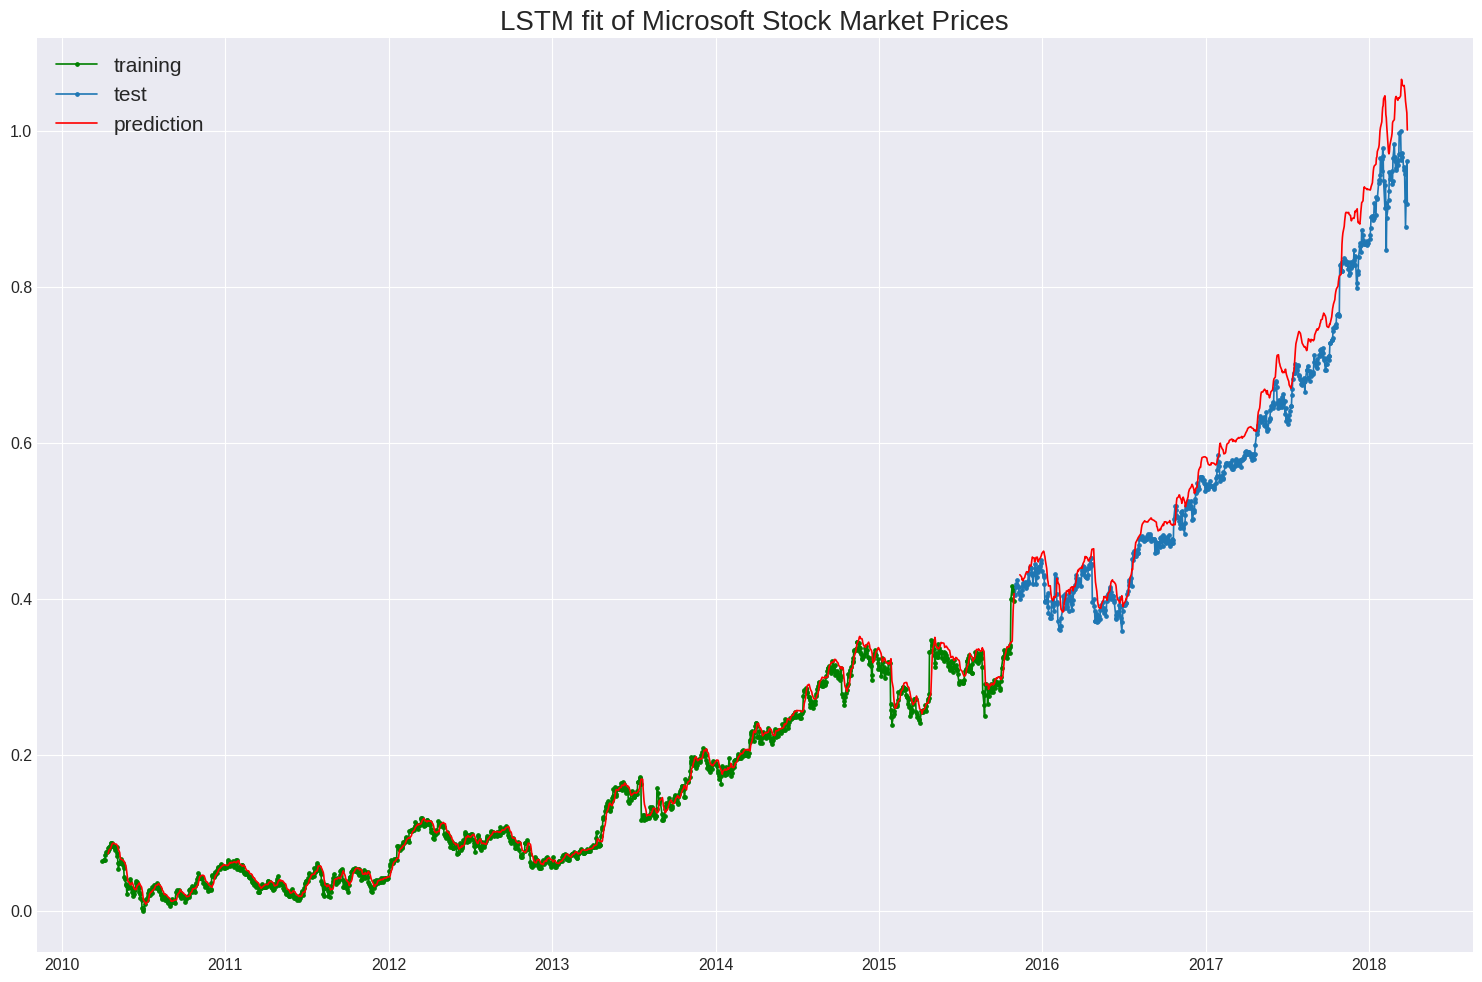

In [ ]:
time_y_train = pd.DataFrame(data = train_y, index = result[0:train_size].index,columns= [""])
time_y_test  = pd.DataFrame(data = test_y, index = result[train_size:].index,columns= [""])

time_y_train_prediction = pd.DataFrame(data = train_predict, index = time_y_train[8:].index,columns= [""])
time_y_test_prediction  = pd.DataFrame(data = test_predict, index = time_y_test[8:].index,columns= [""])


plt.style.use('seaborn-v0_8-dark')
plt.figure(figsize=(15,10))

plt.plot(time_y_train,label = "training",color ="green",marker='.')
plt.plot(time_y_test,label = "test",marker='.')
plt.plot(time_y_train_prediction,color="red",label = "prediction")
plt.plot(time_y_test_prediction,color="red")
plt.title("LSTM fit of Microsoft Stock Market Prices",size = 20)
plt.tight_layout()
sns.despine(top=True)
plt.ylabel('', size=15)
plt.xlabel('', size=15)
plt.legend(fontsize=15)
plt.grid()

plt.show();

# 2. Second model: modeling the stock market time series with the sentiment analysis of associated online news as extra features

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [ ]:
result= pd.read_pickle("/content/drive/MyDrive/data_to_paper_microsoft_case.pkl")

# original time serie (Y)
y = result.MSFT.values #numpy.ndarray
y = y.astype('float32')
y = np.reshape(y, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y)


# extra information: features of the sentiment analysis
X = result.open.values
X = X.astype('float32')
X = np.reshape(X, (-1, 1))

# training and testing settings (size)
percent_of_training = 0.7
train_size = int(len(y) * percent_of_training)
test_size = len(y) - train_size
#
train_y, test_y = y[0:train_size,:], y[train_size:len(y),:]
train_x, test_x = X[0:train_size,:], X[train_size:len(X),:]



def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
look_back = 7


# features of the original time serie (y)
X_train_features_1, y_train = create_dataset(train_y, look_back)
X_test_features_1, y_test = create_dataset(test_y, look_back)


# calculate extra features in (X)
X_train_features_2, auxiliar_1 = create_dataset(train_x, look_back)
X_test_features_2, auxiliar_2 = create_dataset(test_x, look_back)


# join the all the features in one
## reshape arrays
X_train_features_1 = np.reshape(X_train_features_1, (X_train_features_1.shape[0], 1, X_train_features_1.shape[1]))
X_test_features_1  = np.reshape(X_test_features_1, (X_test_features_1.shape[0], 1, X_test_features_1.shape[1]))
X_train_features_2 = np.reshape(X_train_features_2, (X_train_features_2.shape[0], 1, X_train_features_2.shape[1]))
X_test_features_2  = np.reshape(X_test_features_2, (X_test_features_2.shape[0], 1, X_test_features_2.shape[1]))
## put all together
X_train_all_features = np.append(X_train_features_1,X_train_features_2,axis=1)
X_test_all_features = np.append(X_test_features_1,X_test_features_2,axis=1)


In [ ]:
model = Sequential()
model.add(LSTM(200, input_shape=(X_train_all_features.shape[1], X_train_all_features.shape[2])))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train_all_features,y_train, epochs=300, batch_size=25, validation_data=(X_test_all_features, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0, shuffle=False)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 200)            │       166,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 499,805 (1.91 MB)

 Trainable params: 166,601 (650.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 333,204 (1.27 MB)

In [ ]:
train_predict = model.predict(X_train_all_features)
test_predict  = model.predict(X_test_all_features)




#train_predict = scaler.inverse_transform(train_predict)
#Y_train = scaler.inverse_transform(y_train)
#test_predict = scaler.inverse_transform(test_predict)
#Y_test = scaler.inverse_transform(y_test)


print('Train Mean Absolute Error:', mean_absolute_error(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(np.reshape(y_test,(y_test.shape[0],1)), test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(y_test,(y_test.shape[0],1)), test_predict[:,0])))

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train Mean Absolute Error: 0.008705639280378819
Train Root Mean Squared Error: 0.0114923394725649
Test Mean Absolute Error: 0.031107323244214058
Test Root Mean Squared Error: 0.043746417348066606


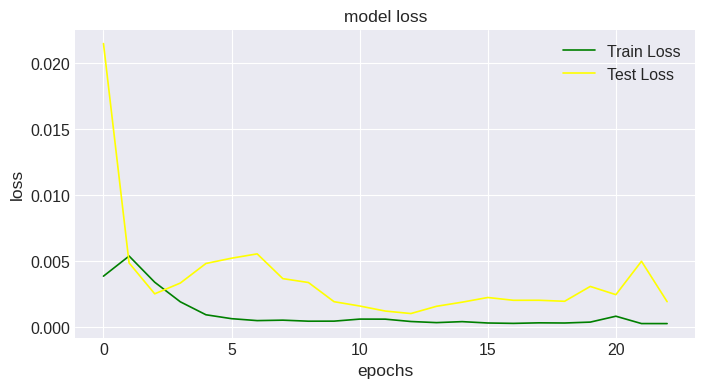

In [ ]:
plt.figure(figsize=(8,4))
plt.style.use('seaborn-v0_8-dark')


plt.plot(history.history['loss'], label='Train Loss',color="green")
plt.plot(history.history['val_loss'], label='Test Loss',color = "yellow")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.grid()

plt.show();

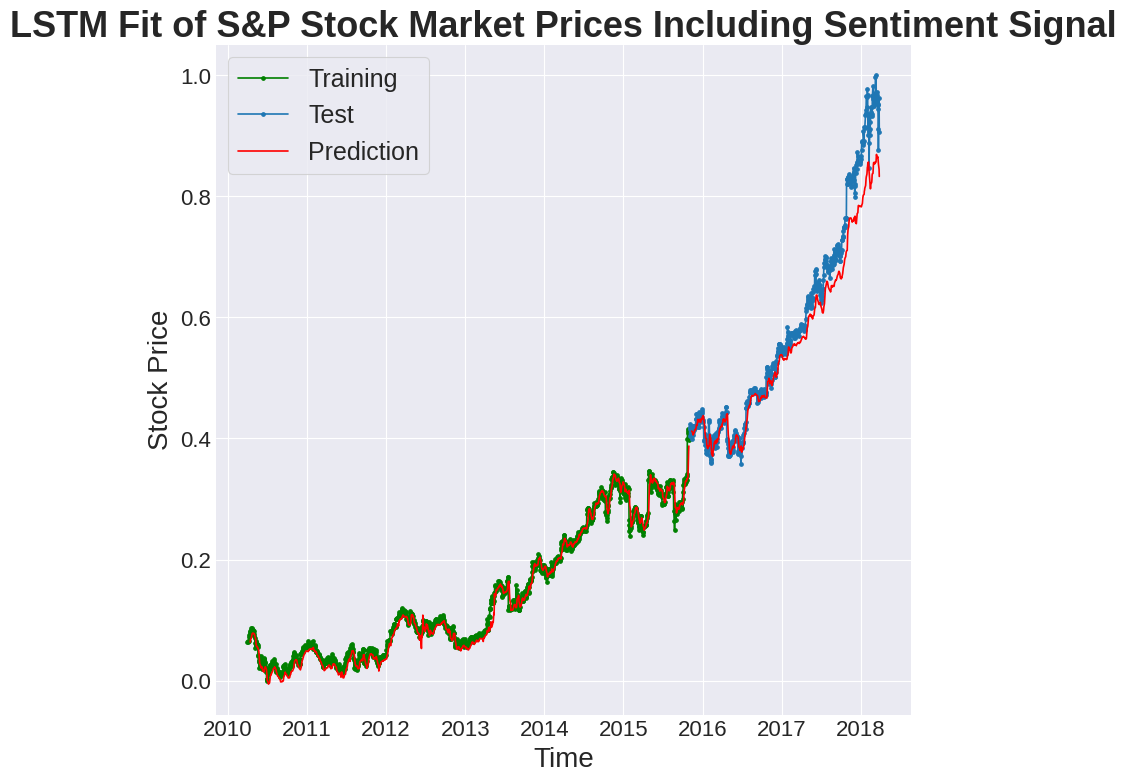

In [ ]:
time_y_train = pd.DataFrame(data = train_y, index = result[0:train_size].index,columns= [""])
time_y_test  = pd.DataFrame(data = test_y, index = result[train_size:].index,columns= [""])

time_y_train_prediction = pd.DataFrame(data = train_predict, index = time_y_train[8:].index,columns= [""])
time_y_test_prediction  = pd.DataFrame(data = test_predict, index = time_y_test[8:].index,columns= [""])


plt.style.use('seaborn-v0_8-dark')
plt.figure(figsize=(8, 8))

# Plotting
plt.plot(time_y_train, label="Training", color="green", marker='.')
plt.plot(time_y_test, label="Test", marker='.')
plt.plot(time_y_train_prediction, color="red", label="Prediction")
plt.plot(time_y_test_prediction, color="red")

# Title and labels
plt.title("LSTM Fit of S&P Stock Market Prices Including Sentiment Signal", fontsize=26, weight='bold')
plt.ylabel("Stock Price", fontsize=20)
plt.xlabel("Time", fontsize=20)

# Tick label size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Legend styling
plt.legend(fontsize=18, title_fontsize=40, loc="upper left", frameon=True)

# Grid and layout
plt.tight_layout()
sns.despine(top=True)
plt.grid()
plt.show()
